2つの分散送信電力制御のプログラム  
仮定として、$Γ_{i}$はそれぞれの所要SINR、利得$G_{i,j}$と平均雑音電力$σ_{i}$は時間によらずそれぞれ一定とする。

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from concurrent.futures import ThreadPoolExecutor

np.random.seed(42)

送信局と受信局を生成する  
※雑に生成するなら、通信局との関係性の前提条件から$dis_{i,j}$について$dis_{i,j}(i = j) \geq dis_{i,j}(i \neq j)$となることや
$F$の最大固有値が1より小さい($\frac{\Gamma_{2}G_{21}}{G_{22}} \leq \frac{G_{11}}{\Gamma_{1}G_{12}}$)と設定することを気をつける

In [79]:
#Gの決定のためのパラメータ
n=2
wave_len = 0.3 #[m]
txs_pos = 500*(2*np.random.rand(n,2)-1) #[[x,y],...]
distance = 200*np.random.rand(n)
theta = 2*np.pi*np.random.rand(n)
rxs_pos = txs_pos+np.stack([distance*np.cos(theta), distance*np.sin(theta)], 1)
euclid_dis = spatial.distance_matrix(rxs_pos, txs_pos)
txs_pos, rxs_pos, distance

(array([[-125.45988115,  450.71430641],
        [ 231.99394181,   98.6584842 ]]),
 array([[-96.31118153, 461.85100059],
        [252.79852648,  75.40894933]]),
 array([31.20372809, 31.19890407]))

In [80]:
G = np.power(wave_len/(4*np.pi*euclid_dis), 2) #[[G11, G12], [G21, G22]]
Gamma1 = 3
Gamma2 = 2
noise_power1 = 1e-10 #sigma1^2
noise_power2 = 1e-10 #sigma2^2
G

array([[5.85342168e-07, 2.37775621e-09],
       [2.00727138e-09, 5.85523195e-07]])

送信局と受信局の関係を図示

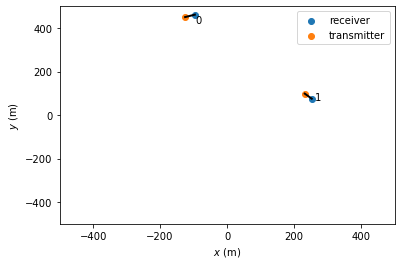

In [81]:
fig, ax = plt.subplots()
ax.set_xlim(-500,500)
ax.set_ylim(-500,500)
ax.set_xlabel("$x$ (m)")
ax.set_ylabel("$y$ (m)")
plt.plot([txs_pos[:,0], rxs_pos[:,0]], [txs_pos[:,1], rxs_pos[:,1]], color='black', linewidth=2)
plt.scatter(rxs_pos[:,0], rxs_pos[:,1], label="receiver")
plt.scatter(txs_pos[:,0], txs_pos[:,1], label="transmitter")
for i in range(2):
  ax.annotate(i, (txs_pos[i,0]+30, txs_pos[i,1]-30))
plt.legend()
plt.show()

更新式  
$p[k+1] = \Gamma_{i} \frac{\sigma_{i}^{2} + \sum_{i \neq j} G_{ij}P_{j}[k]}{G_{ii}} $  
$p[k+1] = \frac{\Gamma_{i}}{\gamma_{i}[k]} P_{i}[k]$　$(\gamma_{i}[k] = \frac{G_{ii}P_{i}[k]}{\sum_{i \neq j} G_{ij}P_{j}[k] + \sigma_{i}^{2}})$   


In [89]:
#for文 
#並列にpiを更新して返り値を取得、それを次のステップの計算に利用
def update_transmit_power1(p1, p2):
    gamma1 = G[0][0]*p1/(G[0][1]*p2+noise_power1)
    newp1 = Gamma1/gamma1*p1
    return newp1
def update_transmit_power2(p1, p2):
    gamma2 = G[1][1]*p2/(G[1][0]*p1+noise_power2)
    newp2 = Gamma2/gamma2*p2
    return newp2

In [97]:
res = [[1.25e-3, 1.25e-3]]
for i in range(10):
    p1 = res[-1][0]
    p2 = res[-1][1]
    if i%2==0:
        p2 = update_transmit_power2(p1, p2)
    if i%2==1:
        p1 = update_transmit_power1(p1, p2)
    res.append([p1,p2])
res

[[0.00125, 0.00125],
 [0.00125, 0.0003501452721151311],
 [0.000516787781193936, 0.0003501452721151311],
 [0.000516787781193936, 0.0003451181240252499],
 [0.0005167265178854332, 0.0003451181240252499],
 [0.0005167265178854332, 0.0003451177039835261],
 [0.0005167265127665975, 0.0003451177039835261],
 [0.0005167265127665975, 0.0003451177039484296],
 [0.0005167265127661698, 0.0003451177039484296],
 [0.0005167265127661698, 0.00034511770394842677],
 [0.0005167265127661696, 0.00034511770394842677]]

図示  
$p2 \geq \Gamma_{2}(\frac{G_{21}}{G_{22}}p_{1}+\frac{\sigma_{2}^{2}}{G_{22}})$  
$p2 \leq (\frac{G_{11}}{\Gamma_{1} G_{12}}p_{1}-\frac{\sigma_{1}^{2}}{G_{12}})$

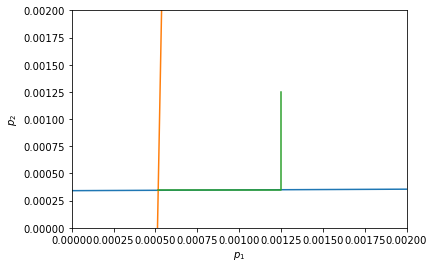

In [95]:
p1 = np.linspace(0,0.01,100)
p21 = Gamma2*(G[1][0]/G[1][1]*p1+noise_power2/G[1][1])
p22 = G[0][0]/(G[0][1]*Gamma1)*p1-noise_power1/G[0][1]
plt.xlim(0,2e-3)
plt.ylim(0, 2e-3)
plt.xlabel("$p_{1}$")
plt.ylabel("$p_{2}$")
plt.plot(p1, p21)
plt.plot(p1, p22)
plt.plot([i[0] for i in res], [i[1] for i in res])
plt.show()

各時点でそれぞれが(分散処理で)最適応答を行う場合

In [54]:
#パラメータをわかりやすい値に設定
G11=G12=G22=G21=1
G =[[G11, G12], [G21,G22]]
Gamma1 = Gamma2 = 0.5
noise_power1 = 3
noise_power2 = 8

res1 = [[2,3]]
for i in range(100):
    with ThreadPoolExecutor(max_workers=n) as executor:
        p1 = res1[-1][0]
        p2 = res1[-1][1]
        newp1 = executor.submit(update_transmit_power1, p1, p2)
        newp2 = executor.submit(update_transmit_power2, p1, p2)
        res1.append([newp1.result(), newp2.result()])

P.S. ある時点で片方が送信電力を更新（SINRが変わったときに送信電力を更新するパターン）

In [55]:
res2 = [[2, 3]]
for i in range(100):
    p1 = res2[-1][0]
    p2 = res2[-1][1]
    if i%2==0:
        p2 = update_transmit_power2(p1, p2)
    if i%2==1:
        p1 = update_transmit_power1(p1, p2)
    res2.append([p1,p2])

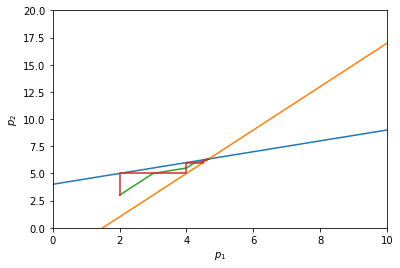

In [56]:
x = np.linspace(0,10,100)
y1 = 0.5*x+4
y2 = 2*x-3
plt.xlim(0, 10)
plt.ylim(0, 20)
plt.plot(x, y1)
plt.plot(x, y2)
plt.xlabel("$p_{1}$")
plt.ylabel("$p_{2}$")
plt.plot([i[0] for i in res1], [i[1] for i in res1])
plt.plot([i[0] for i in res2], [i[1] for i in res2])